In [ ]:
import fbprophet 
import pandas as pd
from math import sqrt
import warnings
# don't do this at home
warnings.filterwarnings("ignore")


# def validate():
"""
>> takes in 
    > Census 1970-2010 dataframe (1 df)
        >> total population by Place measurements
    > American Community Survey (ACS) 2011-2017 dataframes (7 dfs)
        >> total population (age & sex) by Place 

>> forges DataFrame of places that have 
    > at least one (1) recording for Census years 1970-2010
    > at least one (1) recording for ACS years 2011-2015

>> test our model v. base on
    > random sample 100 Places
    > random sample 100 Places from bottom half population size
    > random sample 100 Places from top half population size
"""

'''load Train data'''
# population by Place Census 1970-2010 measurements
load_census_place = pd.read_csv('../../data/NHGIS/nhgis0002_csv/nhgis0002_ts_nominal_place.csv',encoding='ISO-8859-1')
# population by Place ACS 2011
load_acs_20l1 = pd.read_csv('../../data/American_Community_Survey/ACS_11_5YR_S0101/ACS_11_5YR_S0101_with_ann.csv',encoding='ISO-8859-1',low_memory=False) 
# population by Place ACS 2012
load_acs_20l2 = pd.read_csv('../../data/American_Community_Survey/ACS_12_5YR_S0101/ACS_12_5YR_S0101_with_ann.csv',encoding='ISO-8859-1',low_memory=False) 
# population by Place ACS 2013
load_acs_20l3 = pd.read_csv('../../data/American_Community_Survey/ACS_13_5YR_S0101/ACS_13_5YR_S0101_with_ann.csv',encoding='ISO-8859-1',low_memory=False) 
# population by Place ACS 2014
load_acs_20l4 = pd.read_csv('../../data/American_Community_Survey/ACS_14_5YR_S0101/ACS_14_5YR_S0101_with_ann.csv',encoding='ISO-8859-1',low_memory=False) 
# population by Place ACS 2015
load_acs_20l5 = pd.read_csv('../../data/American_Community_Survey/ACS_15_5YR_S0101/ACS_15_5YR_S0101_with_ann.csv',encoding='ISO-8859-1',low_memory=False) 


'''load Test data'''
# population by Place ACS 2016
load_acs_20l6 = pd.read_csv('../../data/American_Community_Survey/ACS_16_5YR_S0101/ACS_16_5YR_S0101_with_ann.csv',encoding='ISO-8859-1',low_memory=False) 
# population by Place ACS 2017
load_acs_20l7 = pd.read_csv('../../data/American_Community_Survey/ACS_17_5YR_S0101/ACS_17_5YR_S0101_with_ann.csv',encoding='ISO-8859-1',low_memory=False) 


'''find common places across Census and each train ACS'''
# identify Places measured in 2011 ACS [0 == 'Geography']
acs11places = [place for place in load_acs_20l1['GEO.display-label'][1:]]
# identify Places measured in 2012 ACS 
acs12places = [place for place in load_acs_20l2['GEO.display-label']]
# identify Places measured in 2013 ACS 
acs13places = [place for place in load_acs_20l3['GEO.display-label']]
# identify Places measured in 2014 ACS
acs14places = [place for place in load_acs_20l4['GEO.display-label']]
# identify Places measured in 2015 ACS 
acs15places = [place for place in load_acs_20l5['GEO.display-label']]

# cross 2011-2015, keep coexisting Places
train_places = [place for place in acs11places if place in acs12places and acs13places and acs14places and acs15places]


'''find common places across 2016 & 2017 (test ACSs)'''
# identify Places measured in 2016 ACS (29575) [0 == 'Geography']
acs16places = [place for place in load_acs_20l6['GEO.display-label'][1:]]
# identify Places measured in 2017 ACS (29577)
acs17places = [place for place in load_acs_20l7['GEO.display-label']]

# cross 2017 Places w/ 2016 Places, keep coexisting Places (29551)
base_places = [place for place in acs17places if place in acs16places]


'''find common Places across the Places our model will train on {train_places} 
    and the Places our model can predict on {base_places}'''
# identify Places we can compare our predictions with
measureable_places = [place for place in train_places if place in base_places]


'''clean Census 1970-2010 df (Train)'''
# identify columns needed to make GEO.display-label column (so can pair with ACS DataFrames) 
for_geo_displays = ['PLACE','STATE']
# pull those columns 
to_geo_displays = load_census_place[for_geo_displays]

# mold PLACE column into list with Place formatted as is in GEO.display-label
places_70_10 = [place + ', ' for place in to_geo_displays.PLACE]

# list paired State for each Place
states_70_10 = [state for state in to_geo_displays.STATE]

# merge places_70_10 and states_70_10 into list formatted as GEO.display-label column
GEO_display_label = [ places_70_10[i] + states_70_10[i] for i in range(len(places_70_10))]

# identify columns relevant to our end goal of predicting population for a given place
place_cols_of_interest = ['AV0AA1970', 'AV0AA1980', 'AV0AA1990', 'AV0AA2000', 'AV0AA2010']
# set base dataframe using Census (1970-2010) measurements 
pop_place_70_10_ = load_census_place[place_cols_of_interest]

# add GEO.display-label column from GEO_display_label list
pop_place_70_10_['GEO.display-label'] = GEO_display_label


'''clean American Community Survey (ACS) 2011-2015 dataframes (Train)'''
# ID columns we will be using
columns = ['GEO.display-label', 'HC01_EST_VC01']
# convert 2011
acs_20l1 = load_acs_20l1[columns]
# convert 2012
acs_20l2 = load_acs_20l2[columns]
# convert 2013
acs_20l3 = load_acs_20l3[columns]
# convert 2014
acs_20l4 = load_acs_20l4[columns]
# convert 2015
acs_20l5 = load_acs_20l5[columns]


'''convert Train years to reflect Places only seen in measureable_places'''
# drop Census Places not ideal for measurement (29346)
census_place_populations = pop_place_70_10_.loc[pop_place_70_10_['GEO.display-label'].isin(measureable_places)]
# drop 2011 ACS Places not ideal for measurement (29341)
acs_2011_place_populations = acs_20l1.loc[acs_20l1['GEO.display-label'].isin(measureable_places)]
# drop 2011 ACS Places not ideal for measurement (29341)
acs_2012_place_populations = acs_20l2.loc[acs_20l2['GEO.display-label'].isin(measureable_places)]
# drop 2011 ACS Places not ideal for measurement (29341) 
acs_2013_place_populations = acs_20l3.loc[acs_20l3['GEO.display-label'].isin(measureable_places)]
# drop 2011 ACS Places not ideal for measurement (29341) 
acs_2014_place_populations = acs_20l4.loc[acs_20l4['GEO.display-label'].isin(measureable_places)]
# drop 2011 ACS Places not ideal for measurement (29341) 
acs_2015_place_populations = acs_20l5.loc[acs_20l5['GEO.display-label'].isin(measureable_places)]


'''clean ACS 2016 & 2017 dataframes (Test)
    take a sample of 100 Places to score our model'''
# identify 2016/2017 columns of interest (to measure against)
test_col_of_i = ['GEO.display-label', 'HC01_EST_VC01']

# shrink ACS 2017 df to columns to measure against only 
testd_16_ = load_acs_20l6[test_col_of_i]
# realize ACS 2016 combined measureable_places DataFrame (Baseline) dataframe 
test_16_df_ = testd_16_.loc[testd_16_['GEO.display-label'].isin(measureable_places)]

# shrink ACS 2017 df to columns to measure against only 
testd_17_ = load_acs_20l7[test_col_of_i]
# realize ACS 2017 combined measureable_places DataFrame (Baseline) dataframe 
test_17_df_ = testd_17_.loc[testd_17_['GEO.display-label'].isin(measureable_places)]
# drop Places with 0 value in 2017 (will be sampling from 2017, values of 0 in 2016 are also 0 in 2017 or do not exits)
test_17_df_ = test_17_df_.loc[test_17_df_.HC01_EST_VC01 != '0']

# sample Baseline data for Places to evaluate model 
sample_one_hunnit = test_17_df_.sample(1000)
# list Places for conversion of other Datas
sample_places = [place for place in sample_one_hunnit['GEO.display-label']]


'''adjust Train dataframes to sampled Places'''
# shrink Census DataFrame to sampled Places
_s_census_ = census_place_populations.loc[census_place_populations['GEO.display-label'].isin(sample_places)]
# shrink 2011 ACS df to sampled Places 
_s_acs_2011_ = acs_20l1.loc[acs_20l1['GEO.display-label'].isin(sample_places)]
# shrink 2012 ACS DataFrame to sampled Places 
_s_acs_2012_ = acs_20l2.loc[acs_20l2['GEO.display-label'].isin(sample_places)]
# shrink 2013 ACS df to Places in sample  
_s_acs_2013_ = acs_20l3.loc[acs_20l3['GEO.display-label'].isin(sample_places)]
# shrink 2014 ACS DataFrame to sampled Places 
_s_acs_2014_ = acs_20l4.loc[acs_20l4['GEO.display-label'].isin(sample_places)]
# shrink 2015 ACS df to sampled Places 
_s_acs_2015_ = acs_20l5.loc[acs_20l5['GEO.display-label'].isin(sample_places)]


'''adjust Test dataframes to sampled Places'''
# 2016 ACS df to sampled Places 
test_16_df = test_16_df_.loc[test_16_df_['GEO.display-label'].isin(sample_places)]
# 2017 ACS DataFrame to sampled Places 
test_17_df = test_17_df_.loc[test_17_df_['GEO.display-label'].isin(sample_places)]


'''forge Train DataFrame'''
# set Census index to Places, and forget Place column 
s_census_ = _s_census_.copy().set_index(_s_census_['GEO.display-label'])[['AV0AA1970','AV0AA1980','AV0AA1990','AV0AA2000','AV0AA2010']]
# rename Census columns to years for later datetime conversion
s_census_.columns = ['1970','1980','1990','2000','2010']

# set 2011 index to Places 
s_acs_2011_ = _s_acs_2011_.copy().set_index(_s_acs_2011_['GEO.display-label'])
# rename Census columns to years for later datetime conversion & forget Place column 
s_acs_2011_.columns = ['no','2011']
s_acs_2011_ = s_acs_2011_['2011']

# set 2012 index to Places 
s_acs_2012_ = _s_acs_2012_.copy().set_index(_s_acs_2012_['GEO.display-label'])
# rename Census columns to years for later datetime conversion & forget Place column 
s_acs_2012_.columns = ['no','2012']
s_acs_2012_ = s_acs_2012_['2012']

# set 2013 index to Places 
s_acs_2013_ = _s_acs_2013_.copy().set_index(_s_acs_2013_['GEO.display-label'])
# rename Census columns to years for later datetime conversion & forget Place column 
s_acs_2013_.columns = ['no','2013']
s_acs_2013_ = s_acs_2013_['2013']

# set 2014 index to Places 
s_acs_2014_ = _s_acs_2014_.copy().set_index(_s_acs_2014_['GEO.display-label'])
# rename Census columns to years for later datetime conversion & forget Place column 
s_acs_2014_.columns = ['no','2014']
s_acs_2014_ = s_acs_2014_['2014']

# set 2015 index to Places 
s_acs_2015_ = _s_acs_2015_.copy().set_index(_s_acs_2015_['GEO.display-label'])
# rename Census columns to years for later datetime conversion & forget Place column 
s_acs_2015_.columns = ['no','2015']
s_acs_2015_ = s_acs_2015_['2015']

# forge Train DataFrame and convert NaN values to 0 (assumes population not measured is 0) 
train_df = pd.concat([s_census_,s_acs_2011_,s_acs_2012_,s_acs_2013_,s_acs_2014_,s_acs_2015_],axis=1).fillna(0)


'''forecast 2016 and 2017 populations using model for each sample Place'''
# set out route for forecast tables
out = []
# set out route for 2016 & 2017 Train predictions
train_preds = []
# make DataFrame of column values as datetime
datetimes = pd.DataFrame(data=pd.to_datetime(pd.Series(data=train_df.columns)))
# go though each place in train_df
for i in range(len(train_df)):
    # extract DataFrame for that place
    df = train_df.iloc[i]
    # add datetime values to DataFrame
    df = pd.concat([df.reset_index(),datetimes],axis=1)
    # use fbprophet to make Prophet model
    place_prophet = fbprophet.Prophet(changepoint_prior_scale=0.15)
    # rename Place df's columns to agree with prophet formatting
    df.columns = ['drop','y','ds']
    # adjust df ; forget index column (drop)
    df = df[['ds','y']]
    # fit place on prophet model 
    place_prophet.fit(df)
    # make a future dataframe for 2016 & 2017 years
    place_forecast = place_prophet.make_future_dataframe( periods=3, freq='Y' )
    # establish predictions
    forecast = place_prophet.predict(place_forecast)
    # tag and bag (forecast table)
    out.append(forecast)
    # store 2016 and 2017 predictions
    train_preds.append([forecast[-2:].yhat.values[0],forecast[-2:].yhat.values[1]])


'''make Baseline predictions of 2016 and 2017 population on sample Places'''
# set out route
baseline_preds = []
# go though each place in train_df
for j in range(len(train_df)):
    # extract DataFrame for that place
    df = train_df.iloc[j]
    # identify 2014 population
    prior = int(df['2014'])
    # identify 2015 population
    past = int(df['2015'])
    # calculate change
    change = past - prior
    # make 2016 prediction 
    p_16 = past + change
    # make 2017 prediction 
    p_17 = p_16 + change
    # pair prediction, tag & bag
    baseline_preds.append([p_16,p_17])


'''pull actual measurements for 2016 and 2017 population for each sample Place'''
# actual populations for 2016
test_16 = [actual_population for actual_population in test_16_df.HC01_EST_VC01]
# actual populations for 2017
test_17 = [actual_population for actual_population in test_17_df.HC01_EST_VC01]

In [61]:
len(test_16),len(test_17)

(1000, 1000)

In [63]:
_test_ = [[test_16[i],test_17[i]] for i in range(len(test_17))]
len(_test_)

1000

In [45]:
sample_places

['Lancaster city, Texas',
 'National CDP, Maryland',
 'Cherry Tree borough, Pennsylvania',
 'Roseau city, Minnesota',
 'Bull Hollow CDP, Oklahoma',
 'Fisk city, Missouri',
 'Parshall city, North Dakota',
 'Airmont village, New York',
 'Tri-City CDP, Oregon',
 'Great River CDP, New York',
 'Scribner city, Nebraska',
 'Surf City town, North Carolina',
 'Nichols village, Wisconsin',
 'Kimbolton CDP, Ohio',
 'Colorado Springs city, Colorado',
 'Dover city, Ohio',
 'Summit CDP, Utah',
 'Pleasant View CDP, Pennsylvania',
 'Waverly village, New York',
 'Hatfield CDP, Massachusetts',
 'Flat Rock city, Michigan',
 'Moran city, Kansas',
 'Veneta city, Oregon',
 'Canton borough, Pennsylvania',
 'La Feria North CDP, Texas',
 'Melrose Park village, Illinois',
 'Rosewood Heights CDP, Illinois',
 'Chevy Chase town, Maryland',
 'Whitelaw village, Wisconsin',
 'New London city, Minnesota',
 'Woodhaven city, Michigan',
 'Zurich city, Kansas',
 'Marion city, Kentucky',
 'Yatesville borough, Pennsylvania'

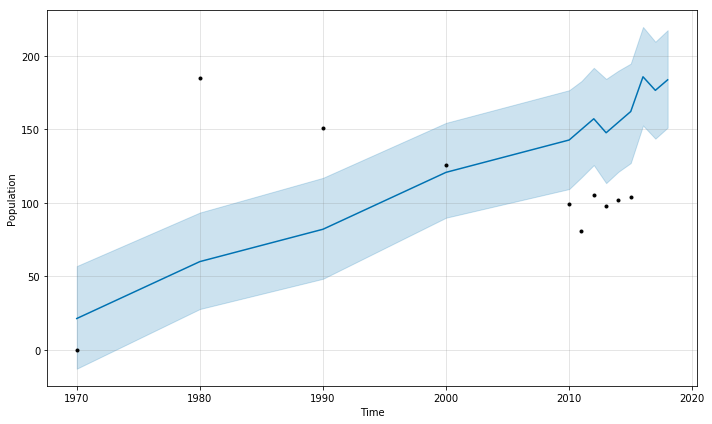

In [55]:
import matplotlib.pyplot as plt
import numpy as np
# Python
fig1 = place_prophet.plot(out[14],xlabel='Time',ylabel='Population')


In [25]:
'''compare Train vs Test to Baseline vs Test
    measure how close (%) Train is to Baseline in compairson to Test'''
# track closeness of Train prediction to actual
measure_2016_train = 0
# track closeness of Baseline prediction to actual
measure_2016_base = 0

# start measuring 2016
for i in range(len(test_16)):
    # add Train error
    measure_2016_train += float(train_preds[i][0])/float(test_16[i])
    # add Baseline error
    measure_2016_base += float(baseline_preds[i][0])/float(test_16[i])

# track closeness of Train prediction to actual
measure_2017_train = 0
# track closeness of Baseline prediction to actual
measure_2017_base = 0

# start measuring 2016
for i in range(len(test_16)):
    # add Train error
    measure_2017_train += float(train_preds[i][1])/float(test_17[i]) 
    # add Baseline error
    measure_2017_base += float(baseline_preds[i][1])/float(test_17[i])

measure_2016_train,measure_2016_base,measure_2017_train,measure_2017_base

(68282.44726931966, 67063.65431749409, 71035.40894957812, 69835.37091369367)

In [22]:
baseline_preds[474][0],train_preds[474][0],test_16[474]

(0, 9.119137684698199, '742')

In [23]:
baseline_preds[474][1],train_preds[474][1],test_16[474]

(0, 9.09789548341562, '742')

In [56]:
from sklearn.metrics import mean_squared_error
from math import sqrt

In [67]:
train_preds_16 = [float(pred[0]) for pred in train_preds]
test_16_ = [float(act) for act in test_16]
rmse_exrate = sqrt(mean_squared_error(y_true=test_16_,y_pred=train_preds_16))
rmse_exrate

54467.22935133883

In [68]:
base_preds_16 = [float(pred[0]) for pred in baseline_preds]
test_16_ = [float(act) for act in test_16]
rmse_exrate = sqrt(mean_squared_error(y_true=test_16_,y_pred=base_preds_16))
rmse_exrate

54453.9300380698